# Промышленность — задача проекта

### 0. Задание на разработку проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

- Критерии оценки проекта «Промышленность»

    Целевой признак: последняя измеренная температура.

    Метрика: MAE

    Критерии оценки

    - MAE > 8.7 — 0 sp
    - 7.6 < MAE ≤ 8.7 — 4 sp
    - 6.8 < MAE ≤ 7.6 — 4.5 sp
    - 6.3 < MAE ≤ 6.8 — 5 sp
    - 6.0 < MAE ≤ 6.3 — 5.5 sp
    - MAE ≤ 6.0 — 6 sp

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

### План проекта

1. Предварительный анализ данных.
2. Агрегация таблицы с мощностями по загрузкам сырья.
3. Объединение таблиц, заполнение пропусков, удаление непригодных данных.
4. Оценка корреляций признаков.
5. Разделение на тестовую и обучающую выборки. Поиск оптимальных гиперпараметров моделей LinearRegression, RandomForestRegressor, LGBMRegressor и XGBRegressor.
6. Тест моделей.
7. Вывод.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [ ]:
plt.rcParams["figure.figsize"] = (15,9)
plt.style.use('seaborn-whitegrid')

### 1. Предварительный анализ данных.




In [ ]:
# Загрузка данных
# path = '/datasets/final_steel/'
path = '/content/drive/MyDrive/Colab_Notebooks/education/final/final_steel/'

df_arc = pd.read_csv(path + 'data_arc.csv')
df_arc.name = 'df_arc'
df_temp = pd.read_csv(path + 'data_temp.csv')
df_temp.name = 'df_temp'
df_gas = pd.read_csv(path + 'data_gas.csv')
df_gas.name = 'df_gas'
df_bulk = pd.read_csv(path + 'data_bulk.csv')
df_bulk.name = 'df_bulk'
df_bulk_time = pd.read_csv(path + 'data_bulk_time.csv')
df_bulk_time.name = 'df_bulk_time'
df_wire = pd.read_csv(path + 'data_wire.csv')
df_wire.name = 'df_wire'
df_wire_time = pd.read_csv(path + 'data_wire_time.csv')
df_wire_time.name = 'df_wire_time'

In [ ]:
# Для удобства обработки соберем df в массив
dfs = [df_arc, df_temp, df_gas, df_bulk, df_bulk_time, df_wire, df_wire_time]

In [ ]:
# Описание данных
for d in dfs:
    print(f'\n=== {d.name} ===')
    print(d.info())


=== df_arc ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None

=== df_temp ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None

=== df_gas ===
<class 'pandas.core.frame

Данные будут объединены по параметру key. Проверим соответсвие этого параметра в таблицах.

In [ ]:
# Соответсвия key полей всех таблиц полю dfs['df_arc']['data']['key']
keys = {}
df_arc_uniq = pd.unique(df_arc['key'])
for item in dfs:
    keys[item.name] =  [list(set(df_arc_uniq) - set(item['key'])),
                        list(set(item['key']) - set(df_arc_uniq))]

# Вывод в виде таблицы
print('{:<15} | {:^15} | {:<10} | {}\n'.format('name','отсутствующие','дополнительные', 'дополнительные'))
for item in keys:
    print(f'{item:<15} | {len(keys[item][0]):^15} | {len(keys[item][1]):^15} | {keys[item][1]}')

name            |  отсутствующие  | дополнительные | дополнительные

df_arc          |        0        |        0        | []
df_temp         |        0        |        2        | [195, 279]
df_gas          |        2        |       27        | [3200, 382, 3207, 2446, 529, 1300, 279, 540, 1437, 2469, 41, 42, 683, 2356, 2103, 2491, 195, 2373, 710, 607, 355, 2278, 1133, 2031, 506, 2683, 766]
df_bulk         |       86        |        1        | [279]
df_bulk_time    |       86        |        1        | [279]
df_wire         |       134       |        1        | [279]
df_wire_time    |       134       |        1        | [279]


Наблюдаем несоответствие данных по загрузкам. В реальной жизни было бы необходимо разобраться с причинами этого явления.

Мы будем ориентироваться на таблицу df_arc - не соответствующие номера выплавок в других таблицах будем игнорировать.

In [ ]:
# Переведем время в timestamp
df_arc['Начало нагрева дугой'] = pd.to_datetime(df_arc['Начало нагрева дугой'])
df_arc['Конец нагрева дугой'] = pd.to_datetime(df_arc['Конец нагрева дугой'])
df_temp['Время замера'] = pd.to_datetime(df_temp['Время замера'])

### 2. Агрегация таблицы с мощностями по загрузкам сырья.

На промышленных предприятиях, как правило, ведется раздельный учет расхода реактивной и активной мощностей. Чтобы иметь возможность просуммировать потребление для каждой выплавки, необходимо перевести мощность, выраженную в Мегаваттах в единицу количества электроэнергии, выраженную в Мегаватт-часах.

$$ 
W (МВт*ч) = S(МВт) * t(с)
$$

Мощность с отрицательным значением:
Empty DataFrame
Columns: [key, Начало нагрева дугой, Конец нагрева дугой, Активная мощность, Реактивная мощность]
Index: []


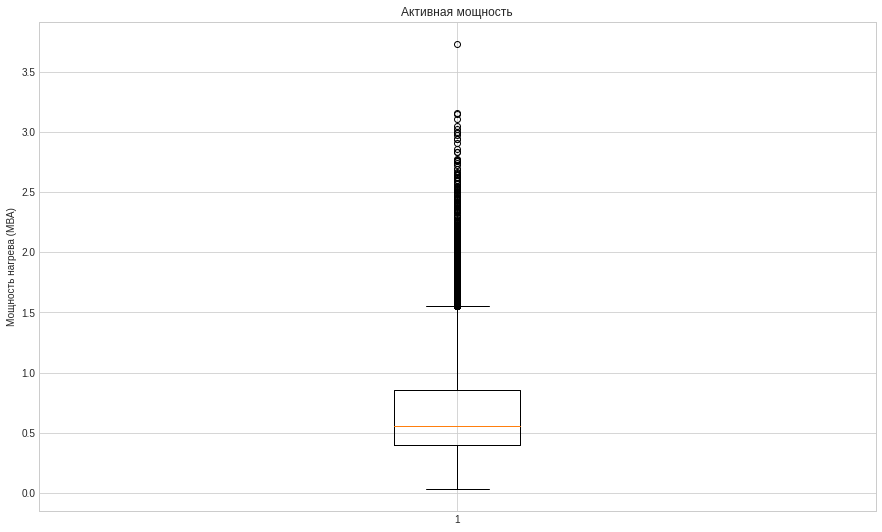

In [ ]:
# Анализ активной мощности
print('Мощность с отрицательным значением:')
print(df_arc[df_arc['Активная мощность']<0])
print('===========')
fig, ax = plt.subplots()
ax.set_title('Активная мощность')
ax.set_ylabel('Мощность нагрева (МВА)')
ax.boxplot(df_arc['Активная мощность']);

In [ ]:
# Анализ реактивной мощности
print('Мощность с отрицательным значением:')
print(df_arc[df_arc['Реактивная мощность']<0])
print('===========')

Мощность с отрицательным значением:
       key Начало нагрева дугой  ... Активная мощность  Реактивная мощность
9780  2116  2019-07-24 00:44:48  ...          0.495782          -715.504924

[1 rows x 5 columns]


Наличие отрицательного значения реактивной мощности, вероятнее всего, связано с переходными процессами в цепях питания печи. С учетом того, что такой замер всего один - можно его удалить.

In [ ]:
df_arc.drop(df_arc[df_arc['Реактивная мощность']<0].index, inplace=True)

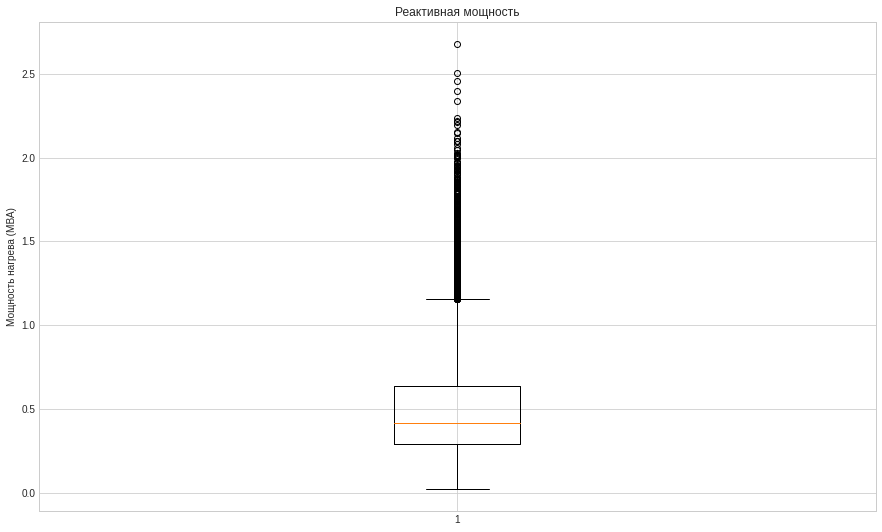

In [ ]:
# Анализ активной мощности
fig, ax = plt.subplots()
ax.set_title('Реактивная мощность')
ax.set_ylabel('Мощность нагрева (МВА)')
ax.boxplot(df_arc['Реактивная мощность']);

In [ ]:
# Функция подсчета расхода активной мощности
def activ_W(row):
    time_h = (row['Конец нагрева дугой'] - row['Начало нагрева дугой'])/pd.Timedelta('1 hour')
    return row['Активная мощность'] * time_h

# Функция подсчета расхода реактивной мощности
def reactiv_W(row):
    time_h = (row['Конец нагрева дугой'] - row['Начало нагрева дугой'])/pd.Timedelta('1 hour')
    return row['Реактивная мощность'] * time_h

In [ ]:
# Добавим столбцы расхода мощностей
df_arc['activ_W'] = df_arc.apply(activ_W, axis=1)
df_arc['reactiv_W'] = df_arc.apply(reactiv_W, axis=1)

In [ ]:
df_arc.head(2)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,activ_W,reactiv_W
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,0.061817,0.043515
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.041399,0.026737


### 3. Объединение таблиц, заполнение пропусков, удаление непригодных данных.

Далее будем собирать данные в итоговую общую таблицу df_result

In [ ]:
# df_result
df = pd.DataFrame({'key': pd.unique(df_arc['key'])})
df.head(2)

,key
0,1
1,2


In [ ]:
# Добавим мощности
other = df_arc.groupby(by='key', as_index=False).sum()[['key', 'activ_W', 'reactiv_W']].set_index('key')
df = df.join(other, on='key')
df.head(2)

,key,activ_W,reactiv_W
0,1,0.335501,0.218863
1,2,0.203838,0.135442


In [ ]:
# Добавим последнее время нагрева
other = df_arc.groupby(by='key', as_index=False).max()[['key', 'Конец нагрева дугой']]\
                        .set_index('key')\
                        .rename(columns={'Конец нагрева дугой':'last_heat_time'})
df = df.join(other, on='key')
df.head(2)

,key,activ_W,reactiv_W,last_heat_time
0,1,0.335501,0.218863,2019-05-03 11:28:37
1,2,0.203838,0.135442,2019-05-03 11:53:18


In [ ]:
# Добавим начальную и конечную температуры а так же время замера конечной температуры
other = df_temp.groupby('key').agg({'Температура': 'first'})
df = df.join(other, on='key')
df = df.rename(columns={'Температура':'first_temp'})
other = df_temp.groupby('key').agg({'Температура': 'last'})
df = df.join(other, on='key')
df = df.rename(columns={'Температура':'last_temp'})
other = df_temp.groupby('key').agg({'Время замера': 'last'})
df = df.join(other, on='key')
df = df.rename(columns={'Время замера':'last_temp_time'})
df.head(2)

,key,activ_W,reactiv_W,last_heat_time,first_temp,last_temp,last_temp_time
0,1,0.335501,0.218863,2019-05-03 11:28:37,1571.0,1613.0,2019-05-03 11:30:39
1,2,0.203838,0.135442,2019-05-03 11:53:18,1581.0,1602.0,2019-05-03 11:59:12


In [ ]:
# Для каждой выплавки определим время введения последней присадки.
# Оно нам понадобится для выявления недостоверных измерений последней температуры
def last_time(row):
    row = pd.to_datetime(row.dropna())
    return row.max()

In [ ]:
df_bulk_time['last_time_add_bulk'] = df_bulk_time.apply(last_time, axis=1)
df_wire_time['last_time_add_wire'] = df_wire_time.apply(last_time, axis=1)

In [ ]:
df_bulk_time.head(2)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,last_time_add_bulk
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52,2019-05-03 11:21:30
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20,2019-05-03 11:46:38


In [ ]:
df_wire_time.head(2)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,last_time_add_wire
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:11:41
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:46:10


In [ ]:
# Добавим полученное время в общую таблицу
df = df.join(df_bulk_time[['key', 'last_time_add_bulk']].set_index('key'), on='key')
df = df.join(df_wire_time[['key', 'last_time_add_wire']].set_index('key'), on='key')
df.head(2)

,key,activ_W,reactiv_W,last_heat_time,first_temp,last_temp,last_temp_time,last_time_add_bulk,last_time_add_wire
0,1,0.335501,0.218863,2019-05-03 11:28:37,1571.0,1613.0,2019-05-03 11:30:39,2019-05-03 11:21:30,2019-05-03 11:11:41
1,2,0.203838,0.135442,2019-05-03 11:53:18,1581.0,1602.0,2019-05-03 11:59:12,2019-05-03 11:46:38,2019-05-03 11:46:10


In [ ]:
# Так же добавим и объемы присадок
df = df.join(df_bulk.set_index('key'), on='key')
df = df.join(df_wire.set_index('key'), on='key')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   key                 3214 non-null   int64         
 1   activ_W             3214 non-null   float64       
 2   reactiv_W           3214 non-null   float64       
 3   last_heat_time      3214 non-null   datetime64[ns]
 4   first_temp          3214 non-null   float64       
 5   last_temp           3214 non-null   float64       
 6   last_temp_time      3214 non-null   datetime64[ns]
 7   last_time_add_bulk  3128 non-null   datetime64[ns]
 8   last_time_add_wire  3080 non-null   datetime64[ns]
 9   Bulk 1              252 non-null    float64       
 10  Bulk 2              22 non-null     float64       
 11  Bulk 3              1298 non-null   float64       
 12  Bulk 4              1014 non-null   float64       
 13  Bulk 5              77 non-null     float64     

Из полученной таблицы удалим следующие выплавки:
1. не имеющие конечную температуру
2. имеющие время нагрева или время добавления присадок позже чем последнее измерение температуры
3. имеющие одинаковую начальную и конечную температуры (выплавки с недостаточным количеством измерений)

In [ ]:
# Условие 1
df.dropna(subset=['last_temp'], inplace=True)

In [ ]:
# Условие 2
df.drop(df[(df.last_temp_time < df.last_heat_time) | 
           (df.last_temp_time < df.last_time_add_bulk) |
           (df.last_temp_time < df.last_time_add_wire)].index, inplace=True)

In [ ]:
# Условие 3
df = df.query('first_temp != last_temp')

In [ ]:
# Удалим лишние столбцы
df.drop(columns=['last_heat_time',
                 'last_temp_time',
                 'last_time_add_bulk',
                 'last_time_add_wire',
                 'key'],
        inplace=True)

In [ ]:
# Удалим поле Wire 5, так как оно не имеет значений
df.drop(columns=['Wire 5'], inplace=True)

In [ ]:
# Остальные пропуски можно заполнить нулями
df = df.fillna(0).reset_index(drop=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2299 entries, 0 to 2298
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   activ_W     2299 non-null   float64
 1   reactiv_W   2299 non-null   float64
 2   first_temp  2299 non-null   float64
 3   last_temp   2299 non-null   float64
 4   Bulk 1      2299 non-null   float64
 5   Bulk 2      2299 non-null   float64
 6   Bulk 3      2299 non-null   float64
 7   Bulk 4      2299 non-null   float64
 8   Bulk 5      2299 non-null   float64
 9   Bulk 6      2299 non-null   float64
 10  Bulk 7      2299 non-null   float64
 11  Bulk 8      2299 non-null   float64
 12  Bulk 9      2299 non-null   float64
 13  Bulk 10     2299 non-null   float64
 14  Bulk 11     2299 non-null   float64
 15  Bulk 12     2299 non-null   float64
 16  Bulk 13     2299 non-null   float64
 17  Bulk 14     2299 non-null   float64
 18  Bulk 15     2299 non-null   float64
 19  Wire 1      2299 non-null  

**Вывод**

Для выполнения задачи проекта, будем рассматривать каждую выплавку как отдельное событие. 
Расход электрической энергии посчитан и просуммирован. Все таблицы агрегированы по номеру выплавки. Истории плавки, не имеющие однозначно определенной конечной температуры удалены.
Остаточная длина набора данных составила 2299 строк. Этого достаточно для подготовки модели, предсказывающей конечную температуру.


### 4. Оценка кореляций признаков.

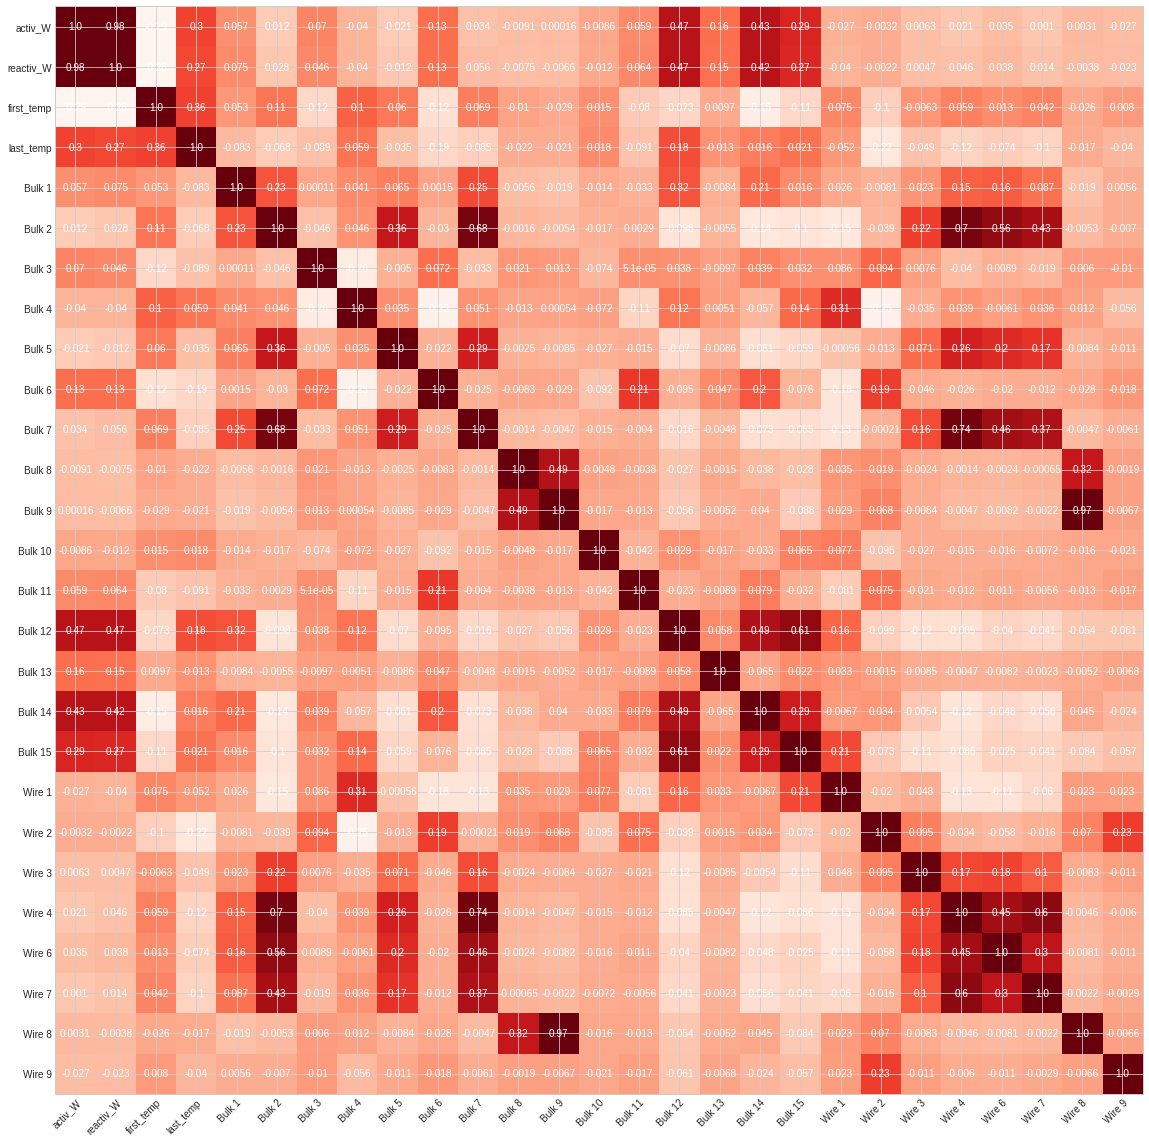

In [ ]:
# Оценка мультиколлинеарности и отсутсвия зависимостей между целевым признаком и остальными.
corr_heatmap_data = df.corr()

fig, ax = plt.subplots(figsize=(20,20))
ax.set_xticks(np.arange(len(corr_heatmap_data.index)))
ax.set_yticks(np.arange(len(corr_heatmap_data.index)))

ax.set_xticklabels(corr_heatmap_data.index)
ax.set_yticklabels(corr_heatmap_data.index)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
data = corr_heatmap_data.values

for i in range(len(corr_heatmap_data.index)):
    for j in range(len(corr_heatmap_data.index)):
        text = ax.text(j, i, '{:.2}'.format(data[i, j]),
                       ha="center", va="center", color="w")
        
ax.imshow(corr_heatmap_data.corr(), cmap='Reds');

Из графика видно, что некоторые параметры слишком сильно зависят друг от друга.

Выведем наиболее коррелирующие параметры.

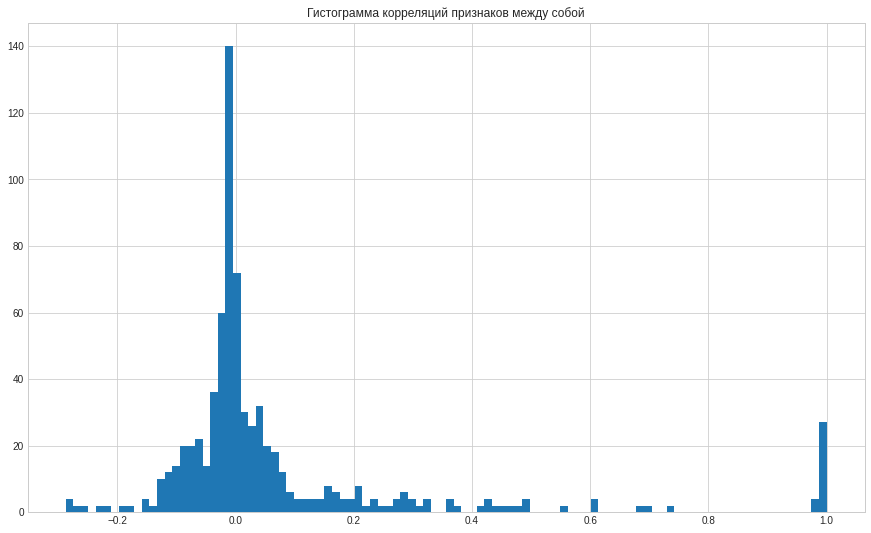

In [ ]:
# Оценим все значения на гистограмме
df_corr_line = df.corr().unstack().sort_values(ascending=False)
df_corr_line.hist(bins=100)
plt.title('Гистограмма корреляций признаков между собой');

In [ ]:
# Признаки, имеющие коэффициент корреляции в пределах 0.85 < k < 1
df_corr_line[(df_corr_line < 1)&(df_corr_line > 0.85)]

activ_W    reactiv_W    0.980173
reactiv_W  activ_W      0.980173
Bulk 9     Wire 8       0.974967
Wire 8     Bulk 9       0.974967
dtype: float64

Наблюдаем зависимости между sum_active_power и sum_reactive_power и bulk_9 и wire_8. Так как они дублируют друг друга, удалим sum_reactive_power и wire_8.

In [ ]:
df.drop(columns=['reactiv_W', 'Wire 8'], inplace=True)
df.shape

(2299, 25)

**Вывод**

Анализ корреляций показал излишние для зависимости, которые были устранены. Теперь можно приступать к обучению и тесту моделей.

### 5. Разделение на тестовую и обучающую выборки. Поиск оптимальных гиперпараметров моделей LinearRegression, RandomForestRegressor, LGBMRegressor и XGBRegressor.

In [ ]:
# Выделим целевой признак
features = df.drop('last_temp', axis=1)
target = df['last_temp']

# Разделим данные тестовую и обучающую выборки в отношении 75% и 25%
random_state = 123
features_train, features_test, target_train, target_test = train_test_split(
                                                            features, 
                                                            target, 
                                                            test_size=0.25, 
                                                            random_state=random_state)
cv_counts = 5

In [ ]:
%%time
# Средний показатель MAE для модели LR
regressor = LinearRegression()
cv_MAE_LR = max(cross_val_score(regressor, 
                             features_train, 
                             target_train, 
                             cv=cv_counts, 
                             scoring='neg_mean_absolute_error')) * -1
print(f'Лучший показатель MAE для модели LinearRegression = {cv_MAE_LR}\n')

Лучший показатель MAE для модели LinearRegression = 7.784310662200517

CPU times: user 32.6 ms, sys: 30.1 ms, total: 62.7 ms
Wall time: 62.9 ms


In [ ]:
%%time
# Подбор гиперпараметров для модели RandomForestRegressor
regressor = RandomForestRegressor() 
hyperparams = [{'criterion':['mse'],
                'n_estimators':[x for x in range(100, 1001, 50)], 
                'random_state':[random_state]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=cv_counts)
clf.fit(features_train, target_train)

print('Оптимальные параметры для модели RandomForestRegressor:\n')
best_params_RFR = clf.best_params_
print(best_params_RFR)

means = clf.cv_results_['mean_test_score']
cv_MAE_RFR = (max(means)*-1)
print(f'\nЛучший показатель MAE для модели RandomForestRegressor = {cv_MAE_RFR}\n')

Оптимальные параметры для модели RandomForestRegressor:

{'criterion': 'mse', 'n_estimators': 400, 'random_state': 123}

Лучший показатель MAE для модели RandomForestRegressor = 6.488536842770479

CPU times: user 8min 27s, sys: 1.78 s, total: 8min 28s
Wall time: 8min 27s


In [ ]:
%%time
# Подбор гиперпараметров для модели XGBRegressor
regressor = XGBRegressor() 
hyperparams = [{'n_estimators':[x for x in range(50, 80, 10)],
                'max_depth':[x for x in range(1, 5)],
                'learning_rate':[x/100 for x in range(20, 30)],
                'random_state':[random_state],
                 'silent':[True]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=cv_counts)
clf.fit(features_train, target_train)

print('Оптимальные параметры для модели XGBRegressor:\n')
best_params_XGBR = clf.best_params_
print(clf.best_params_)

means = clf.cv_results_['mean_test_score']
cv_MAE_XGBR = (max(means)*-1)
print(f'\nЛучший показатель MAE для модели XGBRegressor = {cv_MAE_XGBR}\n')

Оптимальные параметры для модели XGBRegressor:

{'learning_rate': 0.21, 'max_depth': 4, 'n_estimators': 50, 'random_state': 123, 'silent': True}

Лучший показатель MAE для модели XGBRegressor = 6.282029886120371

CPU times: user 44.1 s, sys: 344 ms, total: 44.4 s
Wall time: 44.4 s


In [ ]:
%%time
# Подбор гиперпараметров для модели LGBMRegressor
regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[x for x in range(5, 11)], 
                'learning_rate':[x/100 for x in range(1, 11)],
                'random_state':[random_state]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=cv_counts)
clf.fit(features_train, target_train)

print("Оптимальные параметры для модели LGBMRegressor:\n")
best_params_LGBMR = clf.best_params_
print(clf.best_params_)

means = clf.cv_results_['mean_test_score']
cv_MAE_LGBMR = (max(means)*-1)
print(f'\nЛучший показатель MAE для модели LGBMRegressor = {cv_MAE_LGBMR}\n')

Оптимальные параметры для модели LGBMRegressor:

{'learning_rate': 0.09, 'num_leaves': 6, 'random_state': 123}

Лучший показатель MAE для модели LGBMRegressor = 6.429953901681084

CPU times: user 16 s, sys: 591 ms, total: 16.6 s
Wall time: 16.6 s


**Вывод**

Для определения оптимальных параметров модели был применен метод кросс валидации. На данном этапе мы наблюдаем лучшие показатели для модели LGBMRegressor. В следующем разделе проверим результат на тестовой выборке.

### 6. Тест моделей.

In [ ]:
%%time
# Тест модели LinearRegression
model_LR = LinearRegression()
model_LR.fit(features_train, target_train)
target_predict = model_LR.predict(features_test)
test_MAE_LR = mean_absolute_error(target_predict, target_test)
print(f'MAE для модели LinearRegression = {test_MAE_LR}\n')

MAE для модели LinearRegression = 7.88651245553123

CPU times: user 7.58 ms, sys: 3 ms, total: 10.6 ms
Wall time: 11.1 ms


In [ ]:
%%time
# Тест модели RandomForestRegressor
model_RF = RandomForestRegressor()
model_RF.set_params(**best_params_RFR)
model_RF.fit(features_train, target_train)
target_predict = model_RF.predict(features_test)
test_MAE_RFR = mean_absolute_error(target_predict, target_test)
print(f'MAE для модели RandomForestRegressor = {test_MAE_RFR}\n')

MAE для модели RandomForestRegressor = 6.403978260869565

CPU times: user 4.98 s, sys: 19.9 ms, total: 5 s
Wall time: 5 s


In [ ]:
%%time
# Тест модели XGBRegressor
model_XG = XGBRegressor()
model_XG.set_params(**best_params_XGBR)
model_XG.fit(features_train, target_train)
target_predict = model_XG.predict(features_test)
test_MAE_XGBR = mean_absolute_error(target_predict, target_test)
print(f'MAE для модели XGBRegressor = {test_MAE_XGBR}\n')

MAE для модели XGBRegressor = 6.411862899116848

CPU times: user 96.3 ms, sys: 1.98 ms, total: 98.3 ms
Wall time: 102 ms


In [ ]:
%%time
# Тест модели LGBMRegressor
model_LG = LGBMRegressor()
model_LG.set_params(**best_params_LGBMR)
model_LG.fit(features_train, target_train)
target_predict = model_LG.predict(features_test)
test_MAE_LGBMR = mean_absolute_error(target_predict, target_test)
print(f'MAE для модели LGBMRegressor = {test_MAE_LGBMR}\n')

MAE для модели LGBMRegressor = 6.53106989506637

CPU times: user 59.1 ms, sys: 987 µs, total: 60.1 ms
Wall time: 61.3 ms


In [ ]:
# Итоги
mdls = {'LinearRegression': (cv_MAE_LR, test_MAE_LR), 
        'RandomForestRegressor': (cv_MAE_RFR, test_MAE_RFR),
        'XGBRegressor': (cv_MAE_XGBR, test_MAE_XGBR), 
        'LGBMRegressor': (cv_MAE_LGBMR, test_MAE_LGBMR)}

print('Параметры полученных моделей:\n')
print('{:<30}\t{:^20}\t{:^20}\n'.format('Модель','MAE кросс валидация','MAE тест'))
for item in mdls:
    print(f'{item:<30}\t{mdls[item][0]:^20.4f}\t{mdls[item][1]:^20.4f}')

Параметры полученных моделей:

Модель                        	MAE кросс валидация 	      MAE тест      

LinearRegression              	       7.7843       	       7.8865       
RandomForestRegressor         	       6.4885       	       6.4040       
XGBRegressor                  	       6.2820       	       6.4119       
LGBMRegressor                 	       6.4300       	       6.5311       


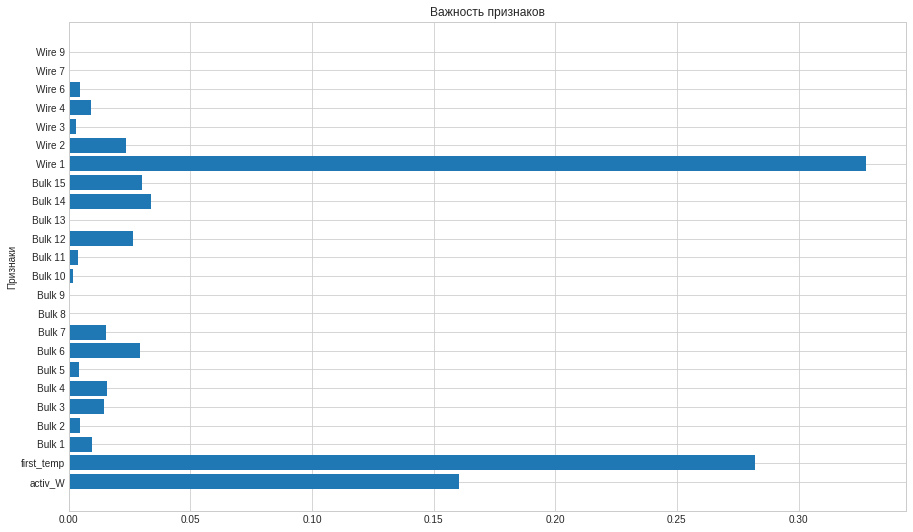

In [ ]:
# Важность признаков
plt.barh(features_test.columns.to_numpy(), model_RF.feature_importances_)
plt.title('Важность признаков')
plt.ylabel('Признаки');

### 7. Вывод

В ходе проделанной работы были определены и конкретизированы задачи проекта, сформулирована методика решения, определены исходные и целевые параметры.

При подготовке признаков были исключены непригодные для моделирования технологического процесса данные, а так же признаки, имеющие излишние корреляционные связи.

В качестве моделей алгоритмов были выбраны следующие:
- LinearRegression
-  RandomForestRegressor
-  XGBRegressor
-  LGBMRegressor

При тесте лучший результат показала модель XGBRegressor MAE = 6.25, что говорит о среднем отклонении в прогнозе конечной температуры не более 6.3 градусов.

LinearRegression показала низкий результат, что говорит о нелинейных связях между признаками и целевым параметром.